In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 50
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon hunter.

It's not about me. I'm a dragon hunter.

I'm a dragon hunter.

When I was a kid, I used to hunt a dragon.

In a small world, I'd eat a dragon.

And I would kill it.

I'd eat it, too.

The dragon hunter was the most important thing to me. I was the most important thing to my friends and family. I was the most important thing to my parents. I was the most important thing to my brothers and sisters. I was the most


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train_sample.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
dataset['model_seeder'].stop_worker()
del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:
<p><msg>c "Hey, Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."<|endoftext|>  ready = false;
     else // успольЗомеля из экраповой норсобля (футулок)
         ready = false ;  
               
 } 
  } 

  else if( усследокус)
 { 
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|

# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
50,1.328800
100,0.993400
150,1.903100
200,1.997200
250,1.782600
300,1.730900
350,1.657000
400,1.623400
450,1.546500
500,1.511000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:533: UserWarning: Length of IterableDataset <model_utils.get_dataset.<locals>.AWSWDataset object at 0x7f9cbc09b400> was reported to be 43 (when accessing len(dataloader)), but 44 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:533: UserWarning: Length of IterableDataset <model_utils.get_dataset.<locals>.AWSWDataset object at 0x7f9cbc09b400> was reported to be 43 (when accessing len(dataloader)), but 45 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:533: UserWarning: Length of IterableDataset <model_utils.get_dataset.<locals>.AWSWDataset object at 0x7f9cbc09b400> was reported to be 43 (when accessing len(dataloader)), but 46 samples have been fetched. 
  warnings.warn(warn_msg)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:533: UserWarning: Len

KeyboardInterrupt: 

KeyError: 'learning_rate_history'

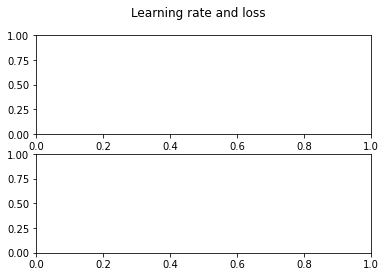

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 899.00 KiB/s, done.
Using framework PyTorch: 1.10.0+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyT

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        !rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model_quant.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragon. Maybe, if I just got out a piece into the workplace, it might not show, because I won't have to work twice as hard. It just doesn't make any sense to me."  | _Dramasurisms._


     **Dramasurisms. **(Dramasurms, _Dramatisms._) **Dramatized by **_Dramis. **(dramatized)

Dramasurisms. **Dry.** **(mak.) **(Dramatizing) **(in.)**


PyTorch: In my dreams, I'm a dragon. I got here early."<p><msg>c "What happened?"<d><scn>park2<msg>Ry "It's a long story."<p><msg>c "I don't mind."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon. In fact it would be my first time, since humanity was founded, I'm not going to have done that again. I'm not going to start.

It would be my first time that humanity is not going to be able, in my view, to do that again.
It was too long. I thought I would have to wait. But I was not.
So, I was not. I wasn<d><scnost>o<msg>Ad "Oh, it's a s

KeyboardInterrupt: 

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [ ]:
test_regular_sampler()

**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Exception in thread Thread-30:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/awsw/model_utils.py", line 67, in buffer_worker
    output = self.onnx_model_manager.say_raw(self.tokenizer.decode([random_input_id])[0], do_sample=True)
  File "/opt/awsw/onnx_model_manager.py", line 62, in say_raw
    noise = np.random.uniform(low = 0.9, high = 1, size = next_token_logits.shape)
NameError: name 'np' is not defined


Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "Well, I'm here now."<d><scn>park2<msg>Ry "I thought you had fun when we went to the park, but you don't have. What are you going to do?"<d><scn>park2<msg>Ry "Well, I'm here now."<d><scn>park2<msg>Ry "I


Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I like the art. It's the art of the human. I like the art. I like the art. I like the art. I like the art. I like the art. I like the art. I like the art. I like the art. I like the art. I like the art. I like the art. I like


Prompt: Oh my god, Adine. What is this?
Reply: o2<msg>Ad "Do you have something you'd like to have me do?"<p><msg>c "You should be more careful."<d><scn>o2<msg>Ad "I'm not sure. I suppose you'll just go ahead and draw the next card, so we can end this."<d><scn>cafe<msg>An "Let's do


Prompt: What will we do here?
Reply: facin3<msg>m "Maybe I'll return to your lab and show you that there's more to the chief of police than getting drunk instead of hea

# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
for i in range(10):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "I don't know. I don't even know where to begin."<d><scn>park2<msg>Ry "Do you ever feel like there is an emptiness inside you? That every day is the same, joyless routine that you wish you could escape - but you can't?"<p><msg>c "I do."<p><msg>c "Hey

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I like the person I've seen in a bad mood."<d><scn>park2<msg>Ry "But this is serious!"<d><scn>park2<msg>Ry " serious!"<d><scn>park2<msg>Ry " serious!"<d><scn>park2<msg

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: o2<msg>Ad "It's the practice of doing flying maneuvers like rolls, spins or loops."<|endoftext|>

[Test 1] -> Prompt: What will we do here?
Reply: facin3<msg>An "Maybe we'll find something you'll like."<p><msg>c "What will you do then?"<d><scn>facin3<msg>An "Let's go then, shall we?"<|endoftext|>

-------------
[Test 2] -> Prompt: How are you?
Reply: park2<msg>Ry "Well, I have my

# RP test
Testing out the injected roleplay actions

In [ ]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')